**Github Link to Notebook and Files:**
https://github.com/ShivanVipani/CS598_Final

Note: Set runtime type to GPU to execute this entire notebook in Google Colab

**Video Presentation Link:** https://drive.google.com/file/d/10NjCOhyjdBFX__QF1AoOJ4-Pgh62tEis/view?usp=drivesdk

**Data Link for Notebook Execution:**

This is the data folder that I have loaded in the root of My Drive in google drive: https://drive.google.com/drive/folders/1HbImyO91P-3BAjdb_MGhQAAndeUMi7mX?usp=sharing

# Mount Notebook to Google Drive
We are using files from the paper's git repo for preprocessing/training/evaluation, but have modified the files so they are executable within Google Colab. Those files will be loaded into this notebook through the above Drive folder, providing python scripts, executable sh scripts, and data from my experiments.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction


**Paper Introduction**
  * what did the paper propose: The paper aims to implement an ensemble learning approach for early diagnosis of sepsis using neural networks, specifically Recurrent Neural Networks (RNNs), trained on patient-specific data. It utilizes temporally-associated clinical measurements, demographic data, and ICU admission/discharge times to predict the onset of sepsis. Leveraging the ensemble's capability to combine diverse patient-specific models, the method seeks to enhance generalization and prediction accuracy.

  * what is the innovations of the method: The method innovates by improving prediction accuracy through ensemble learning while addressing the challenges of privacy preservation in medical data.

  * how well the proposed method work (in its own metrics): According to the paper's metrics, the proposed method achieved significant improvements in prediction accuracy compared to traditional models, particularly in terms of AUROC.

  * what is the contribution to the research regime (referring the Background above, how important the paper is to the problem): Overall, the paper's contributions are significant as it offers a novel approach to sepsis prediction that balances accuracy and privacy concerns, addressing a critical need in the field of medical data analysis.


**Background of the problem**

  * what type of problem: We are predicting sepsis, which occurs when chemicals released in the bloodstream to fight an infection trigger inflammation throughout the body.

  * what is the importance/meaning of solving the problem:  Sepsis can cause a cascade of changes that damage multiple organ systems, leading them to fail, sometimes even resulting in death, which is why it is so important to predict its onset and catch it as early as possible to prevent any damage to the body.

  * what is the difficulty of the problem: Diagnosis is a difficult task when doctors have so much on their plates to crunch numbers on and look out for, and we have overwhelming amounts of population and personal patient data that is hard for the doctor to consume all at once.

  * the state of the art methods and effectiveness:

      1. Machine Learning Techniques:
        * These models leverage various patient data types, such as vital signs, laboratory results, and clinical notes, to identify complex patterns indicative of sepsis onset.
        * Deep learning models like RNNs and CNNs, in particular, have shown promising results in capturing temporal dependencies in patient data and detecting subtle signs of sepsis.

      2. Early Warning Systems (EWS):

        * EWSs continuously monitor patient data streams, including vital signs, laboratory values, and clinical observations, to detect early signs of deterioration, including sepsis.
        * These systems have been successful in triggering timely alerts to healthcare providers, enabling early intervention and improving patient outcomes.
        * EWSs are widely used in clinical settings to support proactive management of high-risk patients and reduce the incidence of sepsis-related complications.

      3. Clinical Decision Support Systems (CDSS):

        * CDSSs integrate patient-specific data with clinical guidelines and evidence-based knowledge to assist healthcare providers in diagnosing and managing sepsis.
        * These systems provide real-time recommendations, alerts, and decision support tools to aid clinicians in identifying sepsis early and guiding appropriate treatment.
        * CDSSs have been shown to improve clinical decision-making, reduce diagnostic errors, and enhance patient safety in sepsis management.

# Scope of Reproducibility:

The paper proposes that an ensemble approach to composing our model using patient-specific models would be more effective, and that creating an entire full model trained on the entirety of the data would yield a poor performing model. In my own time, I put in effort using Google Colab and its GPU engine to train those same models from the experiment, generating a full model and an ensemble model. However, there are approximately 17k patients, and with my hardware specifics available on colab, it would take approx 40 days to complete the experiment. So I had to assess my models on 1/8th of the amount of data by filtering the ids. I additionally created and trained models for my other experiments, involving data splitting and differing ensemble sizes, in this same fashion. Because the data is massive and there are so many patients to make patient-specific models for, I was not able to compete with the results of the authors, which contributed to lower accuracy outcomes than the paper as found below in this notebook. Though I was still impressed that it still did decently well.

For the purposes of reproducibility in this notebook, I've cut down the data to a subsection of patients to train on and build models, so that you can still see everything train and complete/be usable.  The full model takes a very long time to train, so I have cut down its training to 10 epochs as well so that everything can run in this notebook in a timely manner while still displaying the functional execution of everything.

In the git repo, I will provide the files that were used for this adapted reproducible run, in addition to the files and notebooks that were used for my testing in my own time that I executed to get my results.

Execution time and a strong GPU available were definitely constraints for reproduction of this paper, as the paper needs a GPU and the only one I have available is the one provided by Google Colab.

# Methodology


In [2]:
# import  packages you need
import numpy as np
import pandas as pd
from google.colab import drive


##  Environment

**Python Version:**

In [3]:
!python --version

Python 3.10.12


**Dependencies/Packages Needed:**

- PyTorch version >= 1.7.0
- numpy version >= 1.19.4
- scipy version >= 1.6.0
- Python version >= 3.6
- An NVIDIA GPU and NCCL

##  Data

**Data Download:**

In [4]:
!git clone https://github.com/statnlp/sepens
!cd sepens
!wget https://www.cl.uni-heidelberg.de/statnlpgroup/sepsisexp/SepsisExp.tar.gz
!tar zxvf SepsisExp.tar.gz

Cloning into 'sepens'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 53 (delta 21), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (53/53), 37.24 KiB | 3.10 MiB/s, done.
Resolving deltas: 100% (21/21), done.
--2024-05-07 21:08:16--  https://www.cl.uni-heidelberg.de/statnlpgroup/sepsisexp/SepsisExp.tar.gz
Resolving www.cl.uni-heidelberg.de (www.cl.uni-heidelberg.de)... 147.142.207.78
Connecting to www.cl.uni-heidelberg.de (www.cl.uni-heidelberg.de)|147.142.207.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26373703 (25M) [application/x-gzip]
Saving to: ‘SepsisExp.tar.gz’

SepsisExp.tar.gz    100%[===================>]  25.15M  87.4MB/s    in 0.3s    

2024-05-07 21:08:16 (87.4 MB/s) - ‘SepsisExp.tar.gz’ saved [26373703/26373703]

README
sepsisexp_timeseries_partition-A.tsv
sepsisexp_timeseries_partition-B.tsv
sepsisexp_timeseries_partition-C.ts

In [5]:
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/make_data.sh" "/content/sepens/make_data.sh"
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/BI_make_data.sh" "/content/sepens/BI_make_data.sh"
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/TRI_make_data.sh" "/content/sepens/TRI_make_data.sh"

!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/SMALL_grow_ensemble_perrone.py" "/content/sepens/SMALL_grow_ensemble_perrone.py"
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/MEDIUM_grow_ensemble_perrone.py" "/content/sepens/MEDIUM_grow_ensemble_perrone.py"
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/LARGE_grow_ensemble_perrone.py" "/content/sepens/LARGE_grow_ensemble_perrone.py"

!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/make_fullmodel.sh" "/content/sepens/make_fullmodel.sh"
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/make_models_perpat.sh" "/content/sepens/make_models_perpat.sh"
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/make_fullmodel.sh" "/content/sepens/make_fullmodel.sh"

!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/inference_fullmodel.sh" "/content/sepens/inference_fullmodel.sh"
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/inference_poolmodels.sh" "/content/sepens/inference_poolmodels.sh"
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/inference_ensmodels.sh" "/content/sepens/inference_ensmodels.sh"

!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/calc_auroc.py" "/content/sepens/calc_auroc.py"
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/dev_ids.py" "/content/sepens/dev_ids.py"

!cp "/content/drive/My Drive/DL4H_Final_Files/main_root/dev_ids.py" "/content/dev_ids.py"
!cp "/content/drive/My Drive/DL4H_Final_Files/main_root/sorted_filter_train_ids.dat" "/content/sorted_filter_train_ids.dat"
!cp "/content/drive/My Drive/DL4H_Final_Files/main_root/test_ids.dat" "/content/test_ids.dat"

!cp "/content/drive/My Drive/DL4H_Final_Files/data/data_2way/sepsis_partition-E.tsv" "/content/sepsis_partition-E.tsv"
!cp "/content/drive/My Drive/DL4H_Final_Files/data/data_2way/sepsis_partition-F.tsv" "/content/sepsis_partition-F.tsv"
!cp "/content/drive/My Drive/DL4H_Final_Files/data/data_3way/sepsis_partition-G.tsv" "/content/sepsis_partition-G.tsv"
!cp "/content/drive/My Drive/DL4H_Final_Files/data/data_3way/sepsis_partition-H.tsv" "/content/sepsis_partition-H.tsv"
!cp "/content/drive/My Drive/DL4H_Final_Files/data/data_3way/sepsis_partition-I.tsv" "/content/sepsis_partition-I.tsv"
!cp "/content/drive/My Drive/DL4H_Final_Files/data/data_4way/sepsisexp_timeseries_partition-A.tsv" "/content/sepsisexp_timeseries_partition-A.tsv"
!cp "/content/drive/My Drive/DL4H_Final_Files/data/data_4way/sepsisexp_timeseries_partition-B.tsv" "/content/sepsisexp_timeseries_partition-B.tsv"
!cp "/content/drive/My Drive/DL4H_Final_Files/data/data_4way/sepsisexp_timeseries_partition-C.tsv" "/content/sepsisexp_timeseries_partition-C.tsv"
!cp "/content/drive/My Drive/DL4H_Final_Files/data/data_4way/sepsisexp_timeseries_partition-D.tsv" "/content/sepsisexp_timeseries_partition-D.tsv"

!cp "/content/drive/My Drive/DL4H_Final_Files/results.png" "/content/results.png"

**Data Visualizations and Statistics:**

The first split file from each split experiment group is visualized for its class count and its statistic below. The rest of its related split files in their respective groups look similar, so I thought to give a sample from each experiment group rather than clustering the notebook with the same graphs.

In [6]:
# Original 4-Way Split
dfA = pd.read_csv('/content/sepsisexp_timeseries_partition-A.tsv', sep='\t')
#dfB = pd.read_csv('/content/sepsisexp_timeseries_partition-B.tsv', sep='\t')
#dfC = pd.read_csv('/content/sepsisexp_timeseries_partition-C.tsv', sep='\t')
#dfD = pd.read_csv('/content/sepsisexp_timeseries_partition-D.tsv', sep='\t')

# 2-Way Split
dfE = pd.read_csv('/content/sepsis_partition-E.tsv', sep='\t')
#dfF = pd.read_csv('/content/sepsis_partition-F.tsv', sep='\t')

# 3-Way Split
dfG = pd.read_csv('/content/sepsis_partition-G.tsv', sep='\t')
#dfH = pd.read_csv('/content/sepsis_partition-H.tsv', sep='\t')
#dfI = pd.read_csv('/content/sepsis_partition-I.tsv', sep='\t')

In [7]:
dfA.describe()

,id,sepsis,severity,timestep,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,...,calcium,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age
count,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,...,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000,156704.000000
mean,12626.643883,0.606692,1.198712,415.394856,-0.158946,-0.109885,-0.063523,-0.050760,-0.276307,-0.364692,...,0.175648,-0.167095,0.000869,-0.224993,-0.207837,-0.121425,-0.183973,0.291898,0.007869,-0.154681
std,716.262248,0.488486,1.445370,483.193528,1.116563,0.984716,0.841941,0.960839,0.717635,1.230160,...,0.897623,0.841964,0.862454,0.823038,0.681110,0.735095,0.656804,0.843005,0.751659,0.957553
min,11460.000000,0.000000,0.000000,0.000000,-3.033777,-4.288378,-1.777270,-8.067903,-2.812496,-3.427722,...,-8.814428,-5.424779,-4.470184,-0.710447,-7.821855,-0.580261,-0.602295,-2.784903,-2.799802,-3.278467
25%,12066.000000,0.000000,0.000000,83.500000,-0.606959,-0.887358,-0.622171,-0.732387,-0.778690,-1.202032,...,-0.272186,-0.741863,-0.457935,-0.710447,-0.388886,-0.458547,-0.466809,-0.120807,-0.433654,-0.671671
50%,12453.000000,1.000000,1.000000,232.000000,-0.241275,-0.207154,-0.219299,-0.168117,-0.365887,-0.345998,...,0.125127,-0.334653,0.010733,-0.471113,-0.296802,-0.328138,-0.348260,0.317126,0.061715,-0.092383
75%,13201.000000,1.000000,3.000000,565.500000,0.390363,0.521636,0.338181,0.509008,0.137530,0.338830,...,0.522441,0.276162,0.502262,-0.112112,-0.174891,-0.134699,-0.212774,0.463104,0.119831,0.602762
max,14121.000000,1.000000,4.000000,2681.000000,3.615038,4.942962,6.003663,5.926004,6.571205,6.331072,...,6.680801,11.474441,3.268542,19.234050,45.390747,7.757192,7.374421,6.119746,7.882457,1.877196


<Axes: >

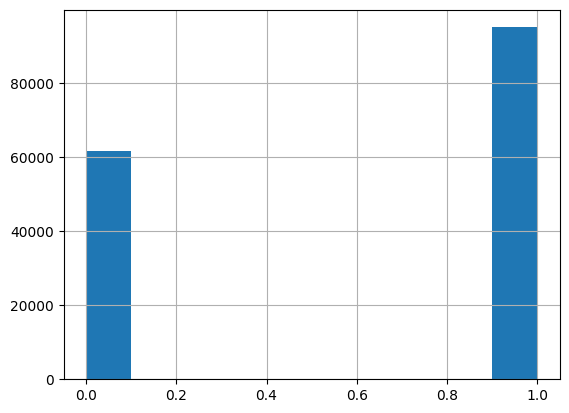

In [8]:
dfA['sepsis'].hist()

In [9]:
dfE.describe()

,id,sepsis,severity,timestep,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,...,calcium,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age
count,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,...,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000,312923.000000
mean,12683.764396,0.611368,1.178405,398.792439,-0.143812,-0.130647,-0.100515,-0.036025,-0.261277,-0.340684,...,0.094899,-0.188788,0.050359,-0.230380,-0.211938,-0.147956,-0.212002,0.295851,0.027617,-0.195689
std,714.633166,0.487440,1.430222,453.685705,1.127586,0.966838,0.866519,0.930156,0.739530,1.199620,...,0.851296,0.851724,0.866251,0.914669,0.724422,0.657474,0.585448,0.850228,0.788856,0.936405
min,11460.000000,0.000000,0.000000,0.000000,-3.033777,-4.288378,-1.856060,-8.067903,-3.205162,-3.427722,...,-8.814428,-5.424779,-4.504477,-0.710447,-10.243506,-0.580261,-0.610763,-2.784903,-2.799802,-3.278467
25%,12122.000000,0.000000,0.000000,83.000000,-0.640204,-0.838772,-0.697989,-0.619533,-0.748485,-1.030825,...,-0.371515,-0.741863,-0.343626,-0.710447,-0.389908,-0.449853,-0.475277,-0.120807,-0.350631,-0.671671
50%,12599.000000,1.000000,1.000000,231.000000,-0.241275,-0.207154,-0.256465,-0.055263,-0.355819,-0.345998,...,0.025799,-0.334653,0.010733,-0.471113,-0.297498,-0.310750,-0.348260,0.317126,0.061715,-0.208241
75%,13254.000000,1.000000,2.000000,541.500000,0.456851,0.473050,0.289122,0.509008,0.097257,0.338830,...,0.522441,0.276162,0.536555,-0.112112,-0.176497,-0.136872,-0.212774,0.499599,0.161343,0.544833
max,14121.000000,1.000000,4.000000,2681.000000,3.615038,5.477408,6.772242,5.926004,6.571205,6.502279,...,6.680801,11.474441,3.382851,24.419619,66.317320,7.965845,7.374421,6.192735,8.173037,1.877196


<Axes: >

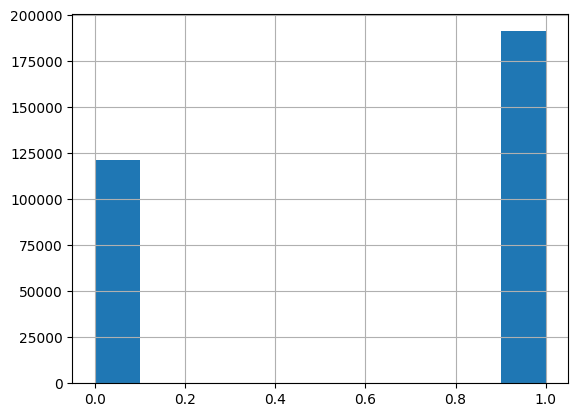

In [10]:
dfE['sepsis'].hist()

In [11]:
dfG.describe()

,id,sepsis,severity,timestep,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,...,calcium,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age
count,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,...,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000,200856.000000
mean,12706.094685,0.473329,0.997755,360.511105,-0.195945,-0.172993,-0.084188,-0.087469,-0.304822,-0.411476,...,0.168036,-0.194279,-0.011246,-0.198092,-0.210419,-0.126252,-0.197307,0.292485,0.084471,-0.160225
std,719.542599,0.499289,1.348313,448.417271,1.080982,0.967198,0.818716,0.926787,0.705036,1.205729,...,0.859518,0.836101,0.879324,1.000088,0.708468,0.726152,0.649713,0.825842,0.795552,0.955271
min,11460.000000,0.000000,0.000000,0.000000,-3.033777,-4.288378,-1.856060,-8.067903,-2.812496,-3.427722,...,-8.814428,-5.424779,-4.470184,-0.710447,-7.821855,-0.580261,-0.602295,-2.784903,-2.799802,-3.278467
25%,12128.000000,0.000000,0.000000,66.500000,-0.640204,-0.887358,-0.635551,-0.732387,-0.788758,-1.373239,...,-0.272186,-0.741863,-0.377918,-0.710447,-0.388707,-0.458547,-0.475277,-0.047818,-0.198423,-0.671671
50%,12594.000000,0.000000,0.000000,190.000000,-0.307763,-0.304326,-0.243085,-0.168117,-0.386024,-0.345998,...,0.125127,-0.334653,0.010733,-0.471113,-0.297491,-0.319444,-0.348260,0.317126,0.061715,-0.092383
75%,13376.000000,1.000000,1.000000,471.000000,0.357119,0.424464,0.302502,0.396154,0.087188,0.338830,...,0.522441,0.276162,0.467969,-0.072223,-0.185004,-0.128178,-0.221242,0.426610,0.216691,0.602762
max,14121.000000,1.000000,4.000000,2681.000000,3.615038,5.137306,6.003663,5.926004,6.571205,6.331072,...,6.680801,11.678045,3.382851,25.217400,46.187344,7.757192,7.780877,6.119746,8.214548,1.877196


<Axes: >

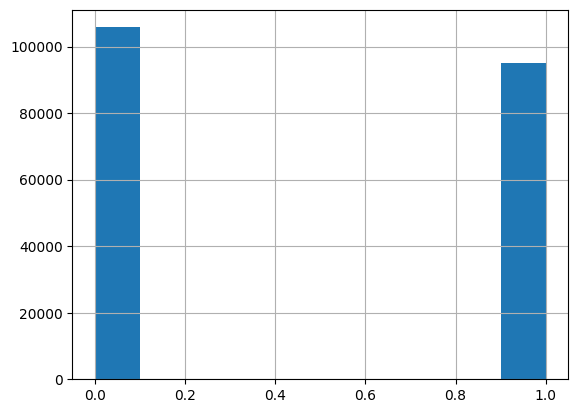

In [12]:
dfG['sepsis'].hist()

Training/Val Splits:

- Original Dataset Split (4-way): ~ 70/30
- 2-way Split: 50/50
- 3-way Split: ~ 67/33

**Preprocessing Code:**

In [13]:
!chmod +x sepens/make_data.sh
!./sepens/make_data.sh 0

INFO: Data files exist, generating train/dev/test splits...
12290 12296 12298 12334 12342 12349 12350 12351 13914 12361 12364 12376 12377 12383 12415 12426 12429 12434 12438 12439 12441 12454 12462 12480 12496 12500 12508 12512 12556 12559 12593 12598 12599 12601 12606 12609 12613 12621 12624 12626 12627 12631 12643 12644 12657 12677 12683 12686 12687 12695 12696 12697 12706 12710 12726 12729 12769 12770 12771 12776 12784 12787 12801 12815 12816 12826 14038 12836 12863 12867 12868 12888 12894 12902 12911 12923 12925 12940 12964 12984 12987 12990 12998 13004 13008 13030 13032 13055 13059 13062 13063 13071 13076 13077 13078 13080 13088 13092 13103 13118 13120 13123 13124 13136 13872 13145 13147 13148 13153 13161 13162 13192 13197 13200 13206 13213 13240 13255 13266 13267 13271 13282 13300 13822 13302 13321 13326 13343 13344 13357 13367 13384 13387 13409 13412 13416 13420 13421 13429 13452 13457 13461 13470 13471 13480 13481 13504 13514 13532 13543 13554 13567 11532 13582 13588 13589 1359

For running the bi-split or tri-split versions of my own experiments (the original execution is a 4-way split) for pre-processing and generating the data that the model uses, you can uncomment your choice of the two cells below and run those instead of the cell above.

In [14]:
#!chmod +x sepens/BI_make_data.sh
#!./sepens/BI_make_data.sh 0

In [15]:
#!chmod +x sepens/TRI_make_data.sh
#!./sepens/TRI_make_data.sh 0

## Model

**Citation Reference of Original Paper:**


1.   Schamoni, S., Hagmann, M., & Riezler, S. (2022). Ensembling Neural Networks for Improved Prediction and Privacy in Early Diagnosis of Sepsis. Proceedings of the 7th Machine Learning for Healthcare Conference, PMLR 182, 123-145. Retrieved from https://doi.org/10.48550/arXiv.2209.00439



```
@inproceedings{schamoni2022,
  author = {Schamoni, Shigehiko and Hagmann, Michael and Riezler, Stefan},
  title = {Ensembling Neural Networks for Improved Prediction and Privacy in Early Diagnosis of Sepsis},
  booktitle = {Proceedings of the 6th Machine Learning for Healthcare Conference},
  year = {2022},
  city = {Durham, NC},
  country = {USA},
  volume = {182},
  series = {Proceedings of Machine Learning Research},
  publisher = {PMLR},
  url = {https://www.cl.uni-heidelberg.de/~schamoni/publications/dl/MLHC2022_Ensembling.pdf}
}
```


**Link to the Original Paper's Repo:**

https://github.com/StatNLP/sepens/tree/main

**Model Descriptions:**

Model Architecture:

It is defined in model_ts.py, a module provided by the paper's repo, that will be visualized below for viewing. The model is not pre-trained, it is trained from scratch off the data we load. The model is trained and validated in main_ts.py, which will be visualized below as well.

2 layers, 200 hidden units per layer

Input Layer:

* Linear layer mapping input features to a specified size.

Recurrent Neural Network (RNN) Layer:

* LSTM: Long-Short Term Memory model.
* Applies dropout for regularization.

Fully Connected (FC) Layer:

* Linear layer mapping RNN output to a single output neuron.

Dropout Layer:

* Applied before input layer and after RNN layer.

Weight Initialization:

* Weights are initialized uniformly, biases are initialized to zero.

Forward Pass:

* Input passes through layers sequentially, reshaping before FC layer.

Hidden State Initialization:

* Initial hidden state is set based on the RNN type.

Training Objectives:

Loss: MSELoss()

Optimizer: torch.nn.utils.clip_grad_norm_()

**Implementation Code:**

model_ts.py:

```
import torch.nn as nn

class RNNModelTS(nn.Module):
    """Container module with an encoder (inp), a recurrent module, and a decoder (fc)."""

    def __init__(self, rnn_type, nfeat, ninp, nhid, nlayers, dropout=0.5):
        super(RNNModelTS, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.inp = nn.Linear(nfeat, ninp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            try:
                nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            except KeyError:
                raise ValueError( """An invalid option for `--model` was supplied,
                                 options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']""")
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
        self.fc = nn.Linear(nhid, 1)

        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.inp.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):

        emb = self.drop(self.inp(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        #
        decoded = self.fc(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))
        else:
            return weight.new_zeros(self.nlayers, bsz, self.nhid)
```



main_ts.py:



```
import argparse
import time
import math
import os
import torch
import torch.nn as nn
import torch.onnx
import data
import model_ts


parser = argparse.ArgumentParser(description='PyTorch SCIDATOS Time Series RNN/LSTM Model')
parser.add_argument('--data', type=str, default='.',
                    help='location of the data corpus')
parser.add_argument('--model', type=str, default='LSTM',
                    help='type of recurrent net (RNN_TANH, RNN_RELU, LSTM, GRU)')
parser.add_argument('--nfeatures', type=int, default=43,
                    help='number of input features (time series)')
parser.add_argument('--insize', type=int, default=200,
                    help='size of input for RNN')
parser.add_argument('--nhid', type=int, default=200,
                    help='number of hidden units per layer')
parser.add_argument('--nlayers', type=int, default=2,
                    help='number of layers')
parser.add_argument('--lr', type=float, default=20,
                    help='initial learning rate')
parser.add_argument('--clip', type=float, default=0.25,
                    help='gradient clipping')
parser.add_argument('--epochs', type=int, default=40,
                    help='upper epoch limit')
parser.add_argument('--min_epochs', type=int, default=10,
                    help='minimum epoch before early stopping')
parser.add_argument('--batch_size', type=int, default=20, metavar='N',
                    help='batch size')
parser.add_argument('--bptt', type=int, default=48,
                    help='sequence length')
parser.add_argument('--seqoverlap', type=float, default=0.5,
                    help='sequence overlap')
parser.add_argument('--dropout', type=float, default=0.2,
                    help='dropout applied to layers (0 = no dropout)')
parser.add_argument('--tied', action='store_true',
                    help='tie the word embedding and softmax weights')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed')
parser.add_argument('--cuda', action='store_true',
                    help='use CUDA')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str, default='model.pt',
                    help='path to save the final model')
parser.add_argument('--onnx-export', type=str, default='',
                    help='path to export the final model in onnx format')
args = parser.parse_args()

# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if args.cuda else "cpu")

###############################################################################
# Load data
###############################################################################

# Load timeseries as torch tensor (cannot be modified)
#timeseries = data.TimeseriesTorch(args.data, args.nfeatures)

# Load timeseries as numpy array (not immutable)
timeseries = data.TimeseriesNumPy(args.data, args.nfeatures)
print("Timeseries loaded")

# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

def batchify(rawdata, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = rawdata[0].size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = rawdata[0].narrow(0, 0, nbatch * bsz)

    # Evenly divide the data across the bsz batches.
    data = data.view(-1, nbatch, args.nfeatures)
    data = data.permute(1,0,2).contiguous()

    ys = rawdata[1].narrow(0, 0, nbatch * bsz)
    ys = ys.view(-1, nbatch, 1)
    ys = ys.permute(1,0,2).contiguous()
    
    return [data.to(device),ys.to(device)]



# Generate overlapping sequences to avoid information loss by unfavorable
# sequence splits

def expand_and_batchify(rawdata, bsz, step=0.5):    
    
    seqlen = args.bptt
    rawlen = int(len(rawdata[0]))
    
    stepsize = int(seqlen*step)
    
    # calculate length of new sequence with overlapa
    timesteps = (math.floor((rawlen-seqlen)/stepsize)+1 ) * seqlen
    timesteps += rawlen - (math.floor((rawlen-seqlen)/stepsize)+1) * stepsize
    
    steps = torch.Tensor(timesteps, args.nfeatures)
    targets = torch.Tensor(timesteps)    # severity

    pos = 0
    for i in range(0, rawlen-seqlen+1, stepsize):
        for j in range(0,seqlen):
            steps[pos] = torch.from_numpy(rawdata[0][i + j])
            targets[pos] = float(rawdata[1][i + j])
            pos += 1
    # copy over remainders
    remainderstart = (math.floor((rawlen-seqlen)/stepsize)+1) * stepsize
    for k in range(remainderstart, rawlen):
        steps[pos] = torch.from_numpy(rawdata[0][k])
        targets[pos] = float(rawdata[1][k])
        pos += 1

    # make sure we have initialized every position
    assert(timesteps == pos)
    
    return batchify([steps,targets], bsz)




eval_batch_size = 10

train_data = expand_and_batchify(timeseries.train, args.batch_size)
val_data = expand_and_batchify(timeseries.valid, eval_batch_size)
test_data = expand_and_batchify(timeseries.test, eval_batch_size)


###############################################################################
# Build the model
###############################################################################

model = model_ts.RNNModelTS(args.model, args.nfeatures, args.insize,
                            args.nhid, args.nlayers, args.dropout).to(device)

criterion = nn.MSELoss()

###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):

    seq_len = min(args.bptt, len(source[0]) - 1 - i)
    data = source[0][i:i+seq_len]

    target = source[1][i:i+seq_len]

    return data, target

def flatten(mydata):
    return mydata.permute(1,0,2).contiguous().view(-1,1)

def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.

    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source[0].size(0) - 1, args.bptt):

            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            
            total_loss += len(data) * criterion(output, targets).item()
            hidden = repackage_hidden(hidden)

    return total_loss / (len(data_source[0]) - 1)


def train():
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    total_xentropy = 0.
    start_time = time.time()
    
    hidden = model.init_hidden(args.batch_size)
    for batch, i in enumerate(range(0, train_data[0].size(0) - 1, args.bptt)):
        data, targets = get_batch(train_data, i)

        hidden = repackage_hidden(hidden)
        model.zero_grad()
        output, hidden = model(data, hidden)
        
        loss = criterion(output, targets)

        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        for p in model.parameters():
            p.data.add_(-lr, p.grad.data)

        total_loss += loss.item()

        if batch % args.log_interval == 0 and batch > 0:
            cur_loss = total_loss / args.log_interval
            cur_xentropy = total_xentropy / args.log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | '
                    'loss {:5.2f} | mse {:8.5f}'.format(
                epoch, batch, len(train_data[0]) // args.bptt, lr,
                elapsed * 1000 / args.log_interval, cur_loss, cur_loss))
            total_loss = 0
            start_time = time.time()


def export_onnx(path, batch_size, seq_len):
    print('The model is also exported in ONNX format at {}'.
          format(os.path.realpath(args.onnx_export)))
    model.eval()
    dummy_input = torch.LongTensor(seq_len * batch_size).zero_().view(-1, batch_size).to(device)
    hidden = model.init_hidden(batch_size)
    torch.onnx.export(model, (dummy_input, hidden), path)


# Loop over epochs.
lr = args.lr
best_val_loss = None

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid mse {:8.5f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, val_loss))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if epoch >= args.min_epochs and (not best_val_loss or val_loss < best_val_loss):
            with open(args.save, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 4.0

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
    # after load the rnn params are not a continuous chunk of memory
    # this makes them a continuous chunk, and will speed up forward pass
    model.rnn.flatten_parameters()

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test mse {:8.5f}'.format(
    test_loss, test_loss))
print('=' * 89)

if len(args.onnx_export) > 0:
    # Export the model in ONNX format.
    export_onnx(args.onnx_export, batch_size=1, seq_len=args.bptt)
```



I have saved some pretrained models in the git repo, but we will be working with live trained models in this notebook.

## Training

**Hyperparams:**

- Learning Rate: 20
- Batch Size: 20
- Dropout: 0.2

**Computational Requirements:**

- Num of Training Epochs:
  - My Own Training
    - Full Model: 200
    - Patient-Specific Models: 20
  - This Notebook
    - Full Model: 10
    - Patient-Specific Models: 20
- Hardware Requirements: Nvidia GPU
- Average Runtime for Each Epoch:
  - My Own Training
    - Full Model: ~ 40 sec
    - Patient-Specific Models: ~ 10 sec
  - This Notebook
    - Full Model: ~ 5 sec
    - Patient-Specific Models: ~ 1 sec
- GPU Hrs Used: ~ 5 Days

**Training Code:**

In [16]:
!chmod +x sepens/make_fullmodel.sh
!./sepens/make_fullmodel.sh

/content/sepens/main_ts.py:241: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  p.data.add_(-lr, p.grad.data)
Timeseries loaded
| epoch   1 |   100/  643 batches | lr 20.00 | ms/batch 15.56 | loss  8.69 | mse  8.69458
| epoch   1 |   200/  643 batches | lr 20.00 | ms/batch  7.00 | loss  8.28 | mse  8.27627
| epoch   1 |   300/  643 batches | lr 20.00 | ms/batch  6.71 | loss  7.51 | mse  7.51477
| epoch   1 |   400/  643 batches | lr 20.00 | ms/batch  6.72 | loss  7.94 | mse  7.94268
| epoch   1 |   500/  643 batches | lr 20.00 | ms/batch  7.22 | loss  7.51 | mse  7.51337
| epoch   1 |   600/  643 batches | lr 20.00 | ms/batch  7.34 | loss  7.55 | mse  7.54779
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  6.96s | v

In [17]:
!chmod +x sepens/make_models_perpat.sh
!./sepens/make_models_perpat.sh

EncNum 12625
/content/sepens/main_ts.py:241: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  p.data.add_(-lr, p.grad.data)
Timeseries loaded
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  1.93s | valid loss 11.64 | valid mse 11.64484
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  1.56s | valid loss  3.50 | valid mse  3.50367
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  1.51s | valid loss  6.32 | v

# Evaluation

These evaluation "inference_" sh scripts from the paper's git repo will help generate all of the model-inferenced datasets so that we can compare all of these results to the ground truth labels at once instead of reloading the ground truth over and over again. The calc_auroc.py is where we get the accuracy metric AUROC (Area Under the Receiver Operating Characteristic Curve) results at the bottom, which measures a model's ability to differentiate between positive and negative classes by plotting the true positive rate against the false positive rate at various classification thresholds.

In [21]:
!chmod +x sepens/inference_poolmodels.sh
!./sepens/inference_poolmodels.sh

EncNum 12625, Model 12625
| Generated 0/5424 timesteps
| Generated 100/5424 timesteps
| Generated 200/5424 timesteps
| Generated 300/5424 timesteps
| Generated 400/5424 timesteps
| Generated 500/5424 timesteps
| Generated 600/5424 timesteps
| Generated 700/5424 timesteps
| Generated 800/5424 timesteps
| Generated 900/5424 timesteps
| Generated 1000/5424 timesteps
| Generated 1100/5424 timesteps
| Generated 1200/5424 timesteps
| Generated 1300/5424 timesteps
| Generated 1400/5424 timesteps
| Generated 1500/5424 timesteps
| Generated 1600/5424 timesteps
| Generated 1700/5424 timesteps
| Generated 1800/5424 timesteps
| Generated 1900/5424 timesteps
| Generated 2000/5424 timesteps
| Generated 2100/5424 timesteps
| Generated 2200/5424 timesteps
| Generated 2300/5424 timesteps
| Generated 2400/5424 timesteps
| Generated 2500/5424 timesteps
| Generated 2600/5424 timesteps
| Generated 2700/5424 timesteps
| Generated 2800/5424 timesteps
| Generated 2900/5424 timesteps
| Generated 3000/5424 time

In [22]:
!python3 sepens/MEDIUM_grow_ensemble_perrone.py 0 | tee logs/grow_ensemble.log
!tail -n1 logs/grow_ensemble.log > new_ensemble.py
!sed "s/ /\n/g" new_ensemble.py | sed 's/[^0-9]*//g' | sed -r '/^\s*$/d' > new_ensemble.lst

INFO: loading timelines and predictions.
ns=1, ss=4
.
no.preds=5
no.labels=24887
INFO: model predictions compiled.
ns_s=1, ss_s=4
1 1.9651270252888657 septic
2 1.9318387374690007 septic
ns = 0 , ss = 2
[(11924, 1.9651270252888657), (12302, 2.3985392957808527)]
-----------
11924
12302
-----------
ensemble = {11924, 12302, }
[(2, 1.9318387374690007), (1, 1.9651270252888657)]


In [23]:
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/new_ensemble.py" "/content/sepens/new_ensemble.py"
!cp "/content/drive/My Drive/DL4H_Final_Files/sepens_folder/ensemble_predictions.py" "/content/sepens/ensemble_predictions.py"

In [24]:
!chmod +x sepens/inference_fullmodel.sh
!./sepens/inference_fullmodel.sh

EncNum 12625
| Generated 0/5424 timesteps
| Generated 100/5424 timesteps
| Generated 200/5424 timesteps
| Generated 300/5424 timesteps
| Generated 400/5424 timesteps
| Generated 500/5424 timesteps
| Generated 600/5424 timesteps
| Generated 700/5424 timesteps
| Generated 800/5424 timesteps
| Generated 900/5424 timesteps
| Generated 1000/5424 timesteps
| Generated 1100/5424 timesteps
| Generated 1200/5424 timesteps
| Generated 1300/5424 timesteps
| Generated 1400/5424 timesteps
| Generated 1500/5424 timesteps
| Generated 1600/5424 timesteps
| Generated 1700/5424 timesteps
| Generated 1800/5424 timesteps
| Generated 1900/5424 timesteps
| Generated 2000/5424 timesteps
| Generated 2100/5424 timesteps
| Generated 2200/5424 timesteps
| Generated 2300/5424 timesteps
| Generated 2400/5424 timesteps
| Generated 2500/5424 timesteps
| Generated 2600/5424 timesteps
| Generated 2700/5424 timesteps
| Generated 2800/5424 timesteps
| Generated 2900/5424 timesteps
| Generated 3000/5424 timesteps
| Gener

In [25]:
!chmod +x sepens/inference_ensmodels.sh
!./sepens/inference_ensmodels.sh

EncNum 12625, Model 11924
EncNum 12625, Model 12302
EncNum 12302, Model 11924
EncNum 12302, Model 12302
EncNum 11924, Model 11924
EncNum 11924, Model 12302
EncNum 13700, Model 11924
EncNum 13700, Model 12302
EncNum 11460, Model 11924
EncNum 11460, Model 12302


In [27]:
!python3 sepens/calc_auroc.py

Interval: -4.250000 to -3.750000
full model: 0.5
uniform:    0.0
weighted:   0.0
Interval: -8.250000 to -7.750000
full model: 0.5
uniform:    0.0
weighted:   0.0
Interval: -12.250000 to -11.750000
full model: 0.5
uniform:    0.0
weighted:   0.0
Interval: -12.250000 to -7.750000
full model: 0.5
uniform:    0.0
weighted:   0.0
Interval: -24.250000 to -11.750000
full model: 0.5
uniform:    0.0
weighted:   0.0


# Results

**Table Of Results:**

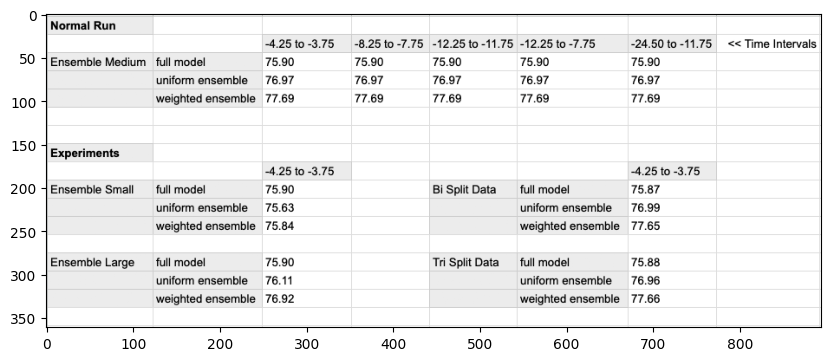

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(plt.imread('results.png'))

**Reflection on Paper's Hypothesis and My Results:**

The paper's original hypothesis had been that the ensemble of patient-specific models could outperform the base full model. In the original paper, the full model averaged around 88.2 and the ensemble averaged uniform 90.5 and weighted 91.3 for the AUROC scores, indicating that the ensemble did indeed outperform the full model by a little bit. Though my own results were evaluated on a sub-section of data (1/8th of data) and thus not run for as long or on as much data, which led to overall lower accuracy results, my results did portray a similar trend. The ensembles outperformed the full model, with the weighted ensemble outpeforming the uniform ensemble, all by just a little bit. This was still pleasant to see that the principle seemed to be slightly visible even under a slice of the data.

**Experiments and Ablations:**

The original paper did not discuss how it arrived at its chosen ensemble size. I dug through its code to find where the ensemble growing algorithm was, which gave me a lever that controlled how large the ensemble was able to get when testing out different patient-specific models. I decided to a test an ablation of different ensemble sizes to see how the components of the model contributed to the experiment.

Their original ensemble averaged a size of 41 models, so I tested the MEDIUM_grow.py file with that size as the normal/original experiment. As my other experiments with this, I tested a size limit of 20 with the SMALL_grow.py file and a limit of 150 with the LARGE_grow.py file. I found from my tests that this didn't affect the ensembles a whole lot in their accuracy, and if anything made them a bit more inaccurate, which gives credence to the chosen 41 number for the amount of models that was used in the original paper's ensemble. Because this experiement was focused on the ensemble size, it of course did not change the outcome of the full base model's results.

The original paper had additionally split up and sampled the data to assign to the models for training. They were grouping 4 patients at a time to provide as data, but did not explain too much on that number, nor did they try to assess the experiment with different numbers. I intended to assess the performance on different sampling sizes, like 2 patients and 3 patients, and see how the model’s acccuracy changes. Visualized in the data section above in this notebook, I created data files with these patient splits so I could run the pre-processing and run different executions of the training with these newly generated training/testing pairs.

Trying this out showed me that there wasn't much of a change in accuracy for any of the models that were significant. The full base model perhaps became a little less accurate in the bi-split because it was too many patients to generalize too, while the ensemble maybe thrived under these conditions to sample more patients and find better fits for making predictions on the remainder of the data. The tri-split seemed to be just negligible variation of a similar outcome to the original experiment.

# Discussion

**Implications of Experiment Results:**

My experiment results showed me that the original paper was correct in the ensemble size they went with, as it maximized its prediction accuracy of the ensemble models. I also found that the split that the original paper applied was appropriate to use as their sampling technique, and that my proposed splits to test out of 2-way and 3-way did not affect the outcome too heavily. I do think that this lack of impact may have also been due to my usage of only a portion of the data (1/8th), so possibly with the whole data set we would have seen more drift between the full model and te ensemble, as patient-specific models maybe get an advantage with the patients available to choose from to build the ensemble.

**Reproducibility of the Paper:**

The paper is mostly reproducible, especially its code segments, as I was able to execute all parts of it successfully from their repo. I think achieving the same accuracy and being able to test all portions of the experiment is just a matter of GPU power andd available time to run the GPU for, but other than that, this is quite reproducible. A CPU option would certainly make this more accessible to people, as that allows them to run these tests for as long as neeeded, but without any concern of cloud engines locking out/shutting down/timing out because of running for too long. The data size is what made this paper's reproducibility strained, as it required an extremely long time to complete all the training using Colab's GPU. But with more time given, this could be fully reproducible.

**What Was Easy:**
Using the code from the paper's git repo was relatively easy was I figured out how each individual file worked and was related to each other. After learning how to execute those files in Google Colab, I was able to build a smooth running system for myself to test different experiments. Loading the data and pre-processing it was especially a breeze thanks to the git repository.

**What Was Difficult:**

The GPU was a severe struggle for me, as it is not strong enough to complete things in a manner that allows me to execute the whole experiment and my other experiments in a timely manner. There was too much data to train on, so I had to cut down on that, and battle with Google Colab on getting kicked out of GPU access while I was working on things due to the amount of time needed to execute. I had to learn how to adapt by keeping my machine open and logged in, avoiding deactivation and doing proper testing to figure out what subset of data would be doable for my own testing as well as demo execution in this notebook.

**Recommendations to the Original Authors for Improving Reproducibility:**

I think it would help with reproducibility to provide an option to run all of these experiments using a CPU, that way it is more accessible to users looking to test (even if the tests take an extremely long time to complete). Other than that, they did a great job providing helpful files in their repo to use for executing all of the training and evaluation. There is not too much we can do about the amount of data there is to train with and the GPU size that is available to others, nor the amount of titme that would be needed to train on data, so they did the best they could to make this mostly adaptable to regular people/academics.